# Predictive Model
For predicting customer booking behaviour

## 思路
3.推荐模型
（1）初始尝试模型
可以从简单模型入手，快速建立基准性能：

逻辑回归（Logistic Regression）：

快速、易于解释，适合线性关系的变量。
结合 class_weight='balanced' 可以缓解类别不平衡问题。
决策树（Decision Tree）：

能处理非线性数据，直观易解释。
适合初步探索变量的重要性。
（2）性能更优的模型
进一步提升性能，可以尝试以下模型：

随机森林（Random Forest）：

抗过拟合能力强，能处理数值和类别型变量。
提供特征重要性，帮助分析变量影响。
XGBoost / LightGBM：

梯度提升算法，通常比随机森林更精确，尤其适合大规模数据。
能很好地处理类别不平衡问题。
（3）处理类别不平衡的技巧
在上述模型中，调整 class_weight 参数（如 RandomForestClassifier(class_weight='balanced')）。
也可以使用欠采样或过采样技术（如 SMOTE）来平衡数据。

4.下一步行动计划
数据预处理：

通过 One-Hot Encoding 将类别型变量转为数值。
检查是否需要对偏态分布变量（如 purchase_lead, length_of_stay）进行标准化或取对数变换。
模型训练与评估：

首先尝试逻辑回归、决策树，建立基准。
然后训练随机森林和 XGBoost，比较其表现。
模型评估：

使用准确率、精确率、召回率、F1 分数等指标。
通过 ROC 曲线和 AUC 值评估模型的分类能力。
特征重要性分析：

用随机森林或 XGBoost 提供的特征重要性图。
使用 SHAP 进一步解释模型对每个特征的依赖。

## 完整步骤 （逻辑回归模型）
1. 数据加载和初步探索
2. 数据清洗和预处理
3. 划分训练集和测试集
4. 模型训练
5. 模型评估
6. 解释模型


### 1. 数据清洗和预处理

In [20]:
# 加载数据，检查数据的基本信息和分布
# 确保数据加载正确，识别可能需要处理的缺失值或异常值

import pandas as pd

# 加载数据
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")

# 初步探索
print(df.head())
print(df.info())
print(df["flight_day"].unique())

# 映射 flight_day
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}
df["flight_day"] = df["flight_day"].map(mapping)
print(df["flight_day"].unique())

# 忽略其他非数值类型数据，只保留数值型的列（包括flight_day 列）
df = df.select_dtypes(include=['number']) 

# 检查缺失值
print(df.isnull().sum())

# 编码类别变量
#df = pd.get_dummies(df, columns=['sales_channel', 'trip_type', 'route', 'booking_origin'], drop_first=True)
# 检查类别变量编码后的特征数
#print(f"Encoded features: {df.shape[1]}")


# 检查目标变量分布
print(df['booking_complete'].value_counts())


# 检查数据处理后的基本信息
print(df.describe())
# 保存预处理后的数据
df.to_csv("data/processed_customer_booking.csv", index=False)
print("Data saved successfully.")



   num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0               2      Internet  RoundTrip            262              19   
1               1      Internet  RoundTrip            112              20   
2               2      Internet  RoundTrip            243              22   
3               1      Internet  RoundTrip             96              31   
4               2      Internet  RoundTrip             68              22   

   flight_hour flight_day   route booking_origin  wants_extra_baggage  \
0            7        Sat  AKLDEL    New Zealand                    1   
1            3        Sat  AKLDEL    New Zealand                    0   
2           17        Wed  AKLDEL          India                    1   
3            4        Sat  AKLDEL    New Zealand                    0   
4           15        Wed  AKLDEL          India                    1   

   wants_preferred_seat  wants_in_flight_meals  flight_duration  \
0                     0        

### 2. 划分训练集和测试集

In [21]:
# 将数据划分为训练集合测试集，确保模型可以被评估

from sklearn.model_selection import train_test_split

# 定义特征变量 X 和目标变量 y
X = df.drop('booking_complete', axis=1)  # 特征
y = df['booking_complete']  # 目标变量

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 确保 X_train 和 X_test 都是 DataFrame，并且包含列名
X_train = pd.DataFrame(X_train, columns=df.drop('booking_complete', axis=1).columns)
X_test = pd.DataFrame(X_test, columns=df.drop('booking_complete', axis=1).columns)


### 3.模型训练

In [22]:
# 训练逻辑回归模型

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# 1. 特征缩放
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. 训练模型
model = LogisticRegression(class_weight='balanced', random_state=42, solver='newton-cg', max_iter=500)
model.fit(X_train_scaled, y_train)




LogisticRegression(class_weight='balanced', max_iter=500, random_state=42,
                   solver='newton-cg')

### 4. 模型评估

In [23]:
# 评估模型在测试集上的表现

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# 预测，评估模型在测试集上的表现
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # 获取正类的概率

# 打印分类报告
print('Classification Report:\n', classification_report(y_test, y_pred))

# 计算 AUC
print('AUC:', roc_auc_score(y_test, y_proba))

# 打印混淆矩阵
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.60      0.71      8504
           1       0.20      0.59      0.30      1496

    accuracy                           0.59     10000
   macro avg       0.55      0.59      0.51     10000
weighted avg       0.79      0.59      0.65     10000

AUC: 0.6198563447336516
Confusion Matrix:
 [[5061 3443]
 [ 614  882]]


### 5. 解释模型

In [24]:
# 1. 查看模型系数。通过逻辑回归的系数了解每个特征对目标变量的影响
import numpy as np

# 查看系数和特征名称
coefficients = model.coef_[0]
features = X.columns

# 创建一个特征重要性表
importance = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
importance = importance.sort_values(by='Coefficient', ascending=False)

# 打印结果
print(importance)



                 Feature  Coefficient
5    wants_extra_baggage     0.198405
6   wants_preferred_seat     0.114383
7  wants_in_flight_meals     0.036853
3            flight_hour     0.020463
0         num_passengers     0.019965
4             flight_day    -0.017366
1          purchase_lead    -0.050542
2         length_of_stay    -0.118707
8        flight_duration    -0.304353


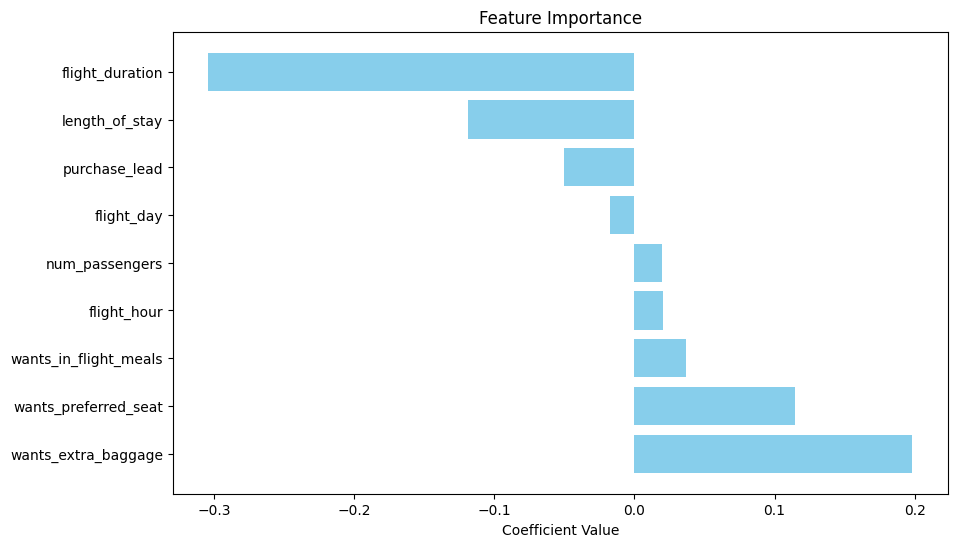

In [25]:
# 2. 可视化特征重要性。用柱状图展示。

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Coefficient'], color='skyblue', height=0.8)
plt.xlabel('Coefficient Value')
plt.title('Feature Importance')

# 旋转y轴标签（让特征名称更容易阅读）
#plt.yticks(rotation=0)  # 或者 plt.yticks(rotation=45) 看是否合适
# 修改字体大小
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=6)



plt.show()
